**Training a classifier to classify poisonous fishes in deep underwater**

Deep learning and I were are in on and off relationship throughout 4-5 years span since I have been in my colleage. The topic of AI always excite me and during last year of my colleage, I decided to specialize in AI. Going through difficult subjects like convolution and calculation of them in matrixes to the easier subjects like tokenization in NLP, I enjoyed every courses in my last year of my bachelor degree regardless of how my grades turned out. 

![](images/puffer.jpg)

I also had taken a computer vision project about identifying the texts such as signs and road names in the street photographs. The project took about six months but the research itself goes on about 2-3 months, setting up everything to work in my own computer with lower level GPU and training time including setting up GPU in python wasn't really a fun experience and it took me many hours to set up a model working with a C++ and C# web interface. After the project, I had just threw away the project since it was too time consuming to set up and there were already better solutions than I did and that was when I didn't come up with my own architecture but research on different models and demonstrate what could be an application for the model and set up the small viable prototype with a working prototype. Curent learners in deep learning wouldn't believe it could take 6 months to do so when this blogpost was done in just a few days of training and setting up in the free websites like Kaggle, Hugging face and GitHub. Stay tuned to follow the rest of this post to set up your own model to deployment with a simple classification model to production or a prototype!!  

I am running this in Kaggle so the following code is just check if your notebook is connected to the internet. 

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

First, I installed fastai and fastbook. Set up fastbook by calling setup_book(). Using fastai is amazingly simple. They have written out these reusable libraries to just call a simple function to handle multiple types of data like images, classification or continuous/table data. Checkout the library to use different dataloaders for your case. 

In [2]:
#hide
!pip install -Uqq fastai fastbook
import fastbook
fastbook.setup_book() 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

The function below will download images with search term from duck duck go API. This API is a life saver for AI computer vision small projects like this since with this, downloading multiple photos is a breeze. The default is 200 photos, but you can adjust this number to download smaller or larger number up to 400 images when I tested out. Larger values give me some error message with "next" value so could be the API issue or the the library doesn't support larger numbers.  

In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

I am just testing out the API and the showing the image result in an Image view. There could be some URLs that which are invalid in API result so in our notebook, after downloading them, we have to clean up those invalid paths. 

In [81]:
search_images_ddg("puffer fish")

(#200) ['http://upload.wikimedia.org/wikipedia/commons/d/df/Spotted_Pufferfish_Arothron_meleagris_02.JPG','http://4.bp.blogspot.com/-L2CRveQMabE/UDecm0P8aaI/AAAAAAAAALY/IJZ6HF43dO4/s1600/pufferfish_673_600x450.jpg','https://1471793142.rsc.cdn77.org/data/images/full/52163/pufferfish.jpg','https://s-media-cache-ak0.pinimg.com/originals/74/e6/d5/74e6d5a92097162ee3c67faa6b187c4f.jpg','https://luvthat.com/wp-content/uploads/2018/06/cute_puffer_fish_01.jpg','https://i.pinimg.com/736x/29/9c/94/299c944301b81bc1a69197a83be08811--picture-search-the-picture.jpg','https://www.thesprucepets.com/thmb/HWyL4x1Y8ADkb1r51mgZxDZqv1U=/3364x2145/filters:fill(auto,1)/black-saddled-toby--canthigaster-valentini--85149304-679070ae2b8a4349a8ea27e2f0ea2c11.jpg','http://3.bp.blogspot.com/_PyA4PaoazEw/TUPE62R0boI/AAAAAAAAAGY/GgGCkFyJY_8/s1600/Puffer+Fish+close+up.jpg','https://bloximages.newyork1.vip.townnews.com/thepilot.com/content/tncms/assets/v3/editorial/7/84/7842f53e-0b44-11e3-a7d3-0019bb30f31a/521636acd0fc5

In [6]:
results = search_images_ddg('puffer fish')
len(results)

200

In [7]:
results[0]

'http://upload.wikimedia.org/wikipedia/commons/d/df/Spotted_Pufferfish_Arothron_meleagris_02.JPG'

In [8]:
dest = 'images/puffer.jpg'
download_url(results[0], dest)

Path('images/puffer.jpg')

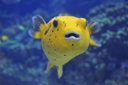

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

I currently have 10 types of underwater poisonous fishes. I create a path and if they aren't downloaded yet I will search them using the library function and download images in the path with the folder name. 

In [10]:
poisonous_fish_types = 'puffer fish','Red Lionfish','Candiru fish', 'Great White Shark', 'Moray Eel', 'Tigerfish', 'Piranha fish', 'Stonefish', 'Atlantic Manta', 'Electric Eel'
path = Path('poisonous')

In [11]:
if not path.exists():
    path.mkdir()
    for o in poisonous_fish_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o}')
        download_images(dest, urls=results)    

In [12]:
fns = get_image_files(path)
fns

(#1944) [Path('poisonous/Atlantic Manta/fcfc5221-8e70-42b6-a816-b1e078a588af.jpg'),Path('poisonous/Atlantic Manta/3fcb2752-146c-4b9f-b727-340273dfdd16.jpg'),Path('poisonous/Atlantic Manta/4044c93f-6a5b-4ba3-aacf-817658a49c92.jpg'),Path('poisonous/Atlantic Manta/43d05f50-9472-45dd-bf51-368771e8fc82.jpg'),Path('poisonous/Atlantic Manta/9a56fc50-b6ec-42b6-8e4e-92654cb7ff69.jpg'),Path('poisonous/Atlantic Manta/cc9d971e-ea29-4c00-b0de-22162602fc0e.jpg'),Path('poisonous/Atlantic Manta/919e6eff-a3ef-486e-b7ea-6d4912a94cca.jpg'),Path('poisonous/Atlantic Manta/9e04bb4c-78bd-4a02-8674-e6bcf5f7c606.jpg'),Path('poisonous/Atlantic Manta/8875ebdb-4b2f-4617-92f1-95995d7bc442.jpg'),Path('poisonous/Atlantic Manta/f97a1601-bd28-4e9e-aa79-338c58a7b581.jpg')...]

I am using verify_images function from fastai library to check for invalid paths in the folder. There are 59 images which are invalid links when downloaded using API returned links. 

In [13]:
failed = verify_images(fns)
failed

(#59) [Path('poisonous/Atlantic Manta/4044c93f-6a5b-4ba3-aacf-817658a49c92.jpg'),Path('poisonous/Atlantic Manta/43d05f50-9472-45dd-bf51-368771e8fc82.jpg'),Path('poisonous/Atlantic Manta/3f4f370d-239b-47ab-ad2a-e1b5c509ec43.jpg'),Path('poisonous/Atlantic Manta/87dda41e-5ba9-473a-af2c-bf85658970c7.jpg'),Path('poisonous/Atlantic Manta/464bcd16-e6ff-4fd5-94ce-1a108c7e59d5.jpg'),Path('poisonous/puffer fish/0f07c3a4-b2f8-45ab-89db-f187a43baf2d.jpg'),Path('poisonous/puffer fish/5e3b67c6-c43c-4204-9a99-309163723152.jpg'),Path('poisonous/puffer fish/8cea2cee-a079-42d7-85f4-92c508c2734e.jpg'),Path('poisonous/puffer fish/c1c82ab4-0868-4e0e-8dd7-ab5dfd4b1a73.png'),Path('poisonous/puffer fish/e941ca09-7664-42b8-9ac6-d776425e3936.jpg')...]

Path.unlink will remove them from path. 

In [14]:
failed.map(Path.unlink);

Here, I am using DataBlock function from fastai, I have ImageBlock as input type and CategoryBlock as output, the datablock won't work without specifying the train and validation split. Here, I will use 20% validation data split in training and validation. Images are resized to 128 px length and width, the categories are the labels of fish type. 

In [15]:
poisonous_fishes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
     

Dataloader is created below by giving a path object. 

In [16]:
dls = poisonous_fishes.dataloaders(path)

We can see the images in the batch as a sample below. 

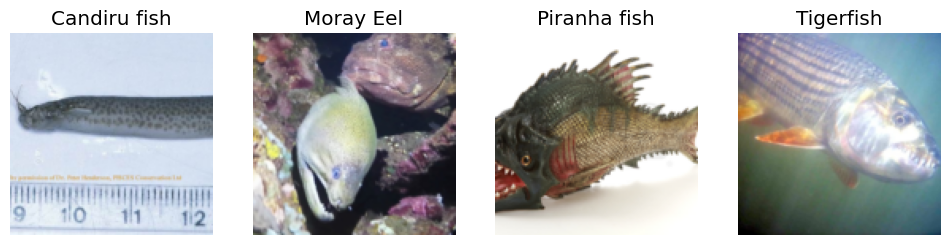

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

Before training, there are two resize methods; one is squish which will readjust the image size and squish them in that resolution if the image is landscape. 

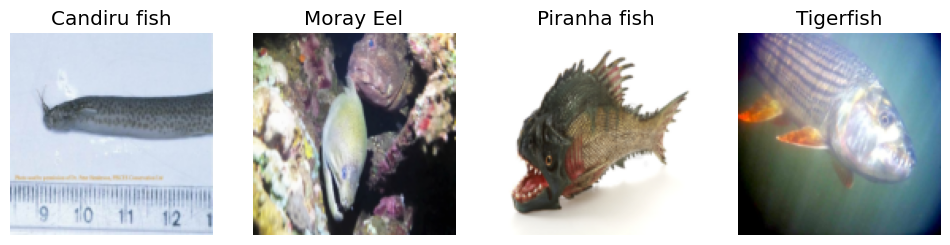

In [18]:
poisonous_fishes = poisonous_fishes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = poisonous_fishes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Padding method below will pad the area missing with the black pixels if they are landscape. 

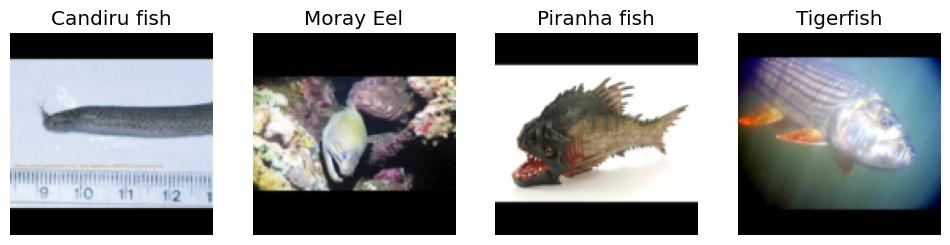

In [19]:
poisonous_fishes = poisonous_fishes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = poisonous_fishes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Randomsize crop will crop the image with the scale defined so the object is photographed at different angles. 

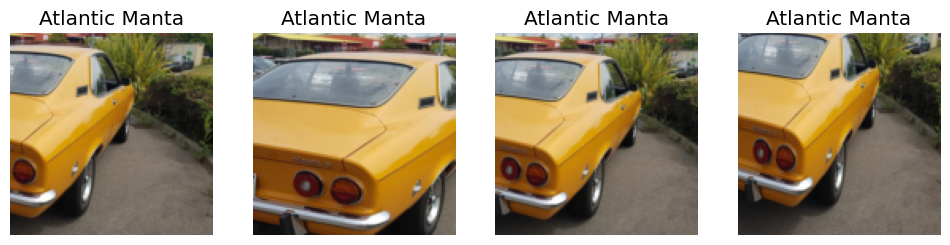

In [20]:
poisonous_fishes = poisonous_fishes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = poisonous_fishes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Now, let's train the model. For data augmentation, aug_trainsforms() function is used so that random transformation is applied in each iteration for the images, the RandomResizedCrop with size 224 (larger) and scale to 0.5 is cropped at different angles of photos to zoom in at different parts of the picture so that the fish body parts are learned in the model. 

In [21]:
poisonous_fishes = poisonous_fishes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = poisonous_fishes.dataloaders(path)

I am using fine_tune here for the resnet pretrained model for transfer learning. Transfer learning is quite popular in recent years with big deep learning projects coming up the magnificent architectures and pretrained with huge datasets of basic objects and animals. We just need to finetune these model in the last layer to solve the classification problem for our dataset. It doesn't need much iteration to train these transfer learning models, just a few iteration lesser than 10 will surffice. In fact, if we train many iterations, the performance will drop since the model will be overfitting to the training data. Therefore, once the validation loss keeps increasing, we should stop before that overfitting happens.  

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.977308,0.443432,0.137931,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.533004,0.333911,0.095491,00:41
1,0.464112,0.294906,0.079576,00:40
2,0.370992,0.306035,0.090186,00:42
3,0.292394,0.340809,0.082228,00:41
4,0.223651,0.301800,0.058355,00:41
5,0.180664,0.298059,0.055703,00:42
6,0.141463,0.288714,0.058355,00:41
7,0.117492,0.281764,0.058355,00:41
8,0.091584,0.280676,0.068966,00:41
9,0.082954,0.281944,0.063660,00:40


The performance is within acceptable range >90% but not that great. 

We can look at confusion matrix to look at where the model misidentify the labels. I am using the function from fastai called ClassificationInterpretation.from_learner() then plot_confusion_matrix(), very useful. We can see some wrong predictions between menta and great white sharks, it could be mislabelling or wrong images. Some confusion between tigerfish and piranha fish is observed too. 

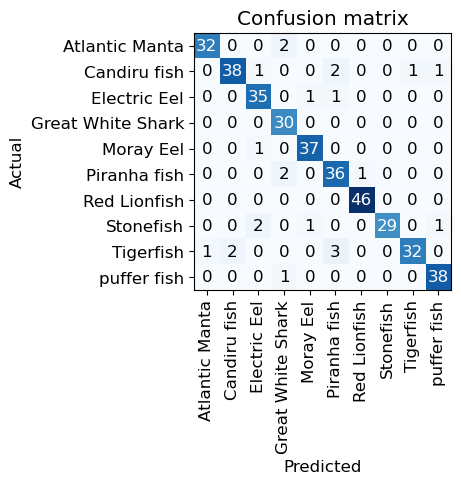

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

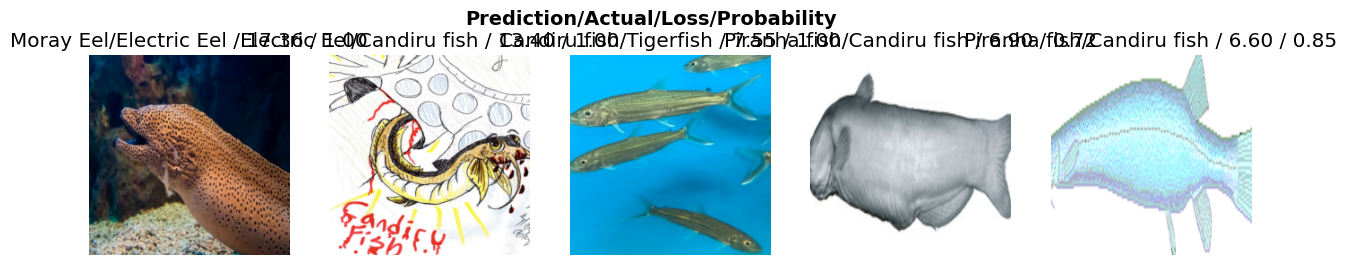

In [24]:
interp.plot_top_losses(5, nrows=1)

Let's use their library function for cleaning up the dataset and we can retrain or rerun the validation with cleaned dataset. Some cartoons pictures like above will have to be removed or any pictures not related to labels can be removed from the dataset using the interface GUI as below. 

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

cleaner.delete() will have the list of images in Delete label and delete them from the path. 
shutil.move as below will move the files to category defined in cleaner.change() list. 

In [37]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
     

Reread the files from the path into the datablock and dataloader. 

In [38]:
poisonous_fishes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [39]:
poisonous_fishes = poisonous_fishes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = poisonous_fishes.dataloaders(path)

Retraining the learner with new set of images.

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.032918,0.461452,0.115281,00:53


epoch,train_loss,valid_loss,error_rate,time
0,0.529132,0.341644,0.096515,00:40
1,0.430419,0.318332,0.080429,00:41
2,0.352638,0.291686,0.075067,00:41
3,0.266597,0.322818,0.088472,00:40
4,0.216012,0.336424,0.088472,00:40
5,0.171814,0.310307,0.069705,00:48
6,0.138518,0.312194,0.069705,01:01
7,0.110297,0.304192,0.067024,00:59
8,0.085691,0.305300,0.061662,00:58
9,0.072290,0.307865,0.064343,00:58


Plotting the confusion matrix shows that there is still confusion between the shark and mata rays. Some images might have left to be cleaned. 

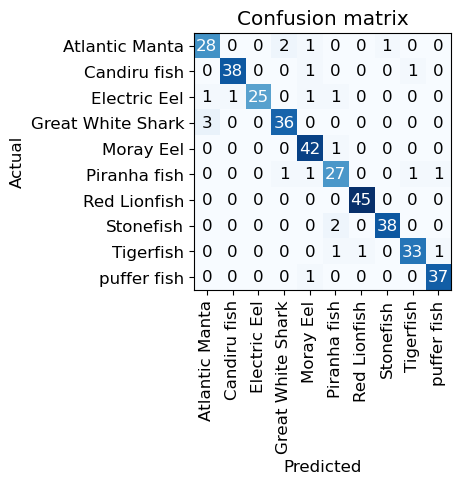

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As seen above, red lion fish is labelled as tiger fish in the validation set, which we have to change the label. We can see that the model helped to clean up the dataset in a way, we can pin point dataset with higher loss/lower confidence to recheck the dataset and instead of going through the dataset one by one which saves a lot of time for data cleaning. Therefore, as mentioned by Jeremy in deep learning course, I agree that it's always a good idea to train the model first with the dataset and cleaning up the data by using the model and retraining is such a good suggestion. We can also see that the third image is neither shark or menta ray which we should remove it. 

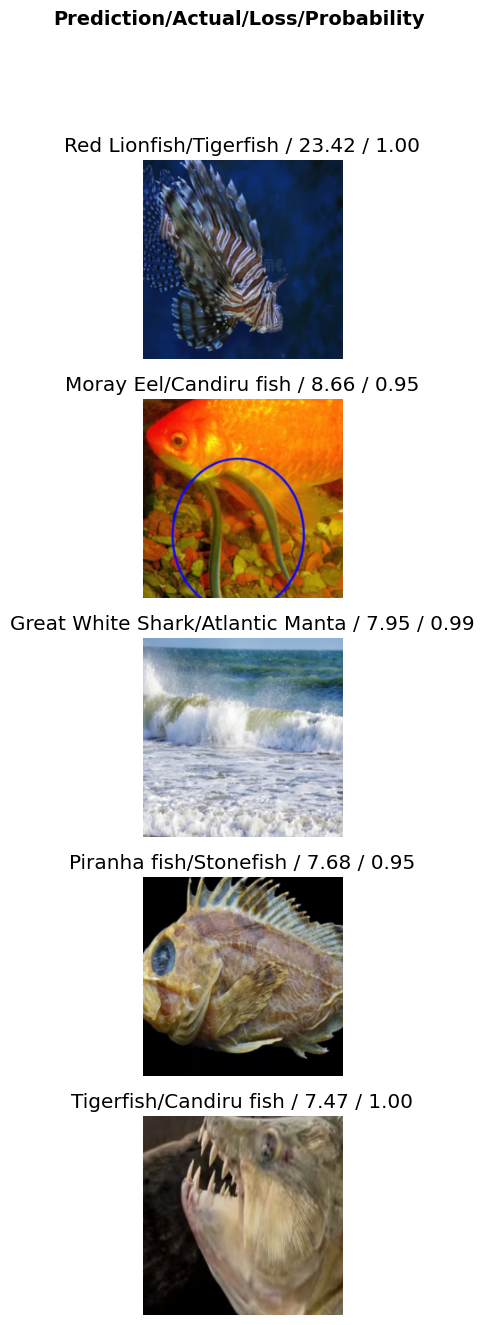

In [44]:
interp.plot_top_losses(5, nrows=5)

Removing those images and changing the labelling when the image should be in another category as below.

In [45]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [52]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

I had to train the model again and repeat the steps. 

In [59]:
poisonous_fishes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = poisonous_fishes.dataloaders(path)

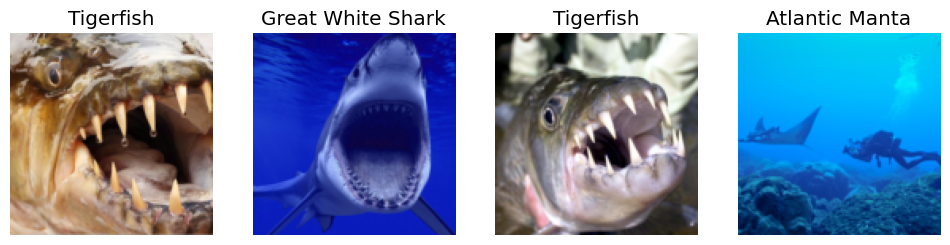

In [60]:
dls.valid.show_batch(max_n=4, nrows=1)

In [61]:
poisonous_fishes = poisonous_fishes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = poisonous_fishes.dataloaders(path)

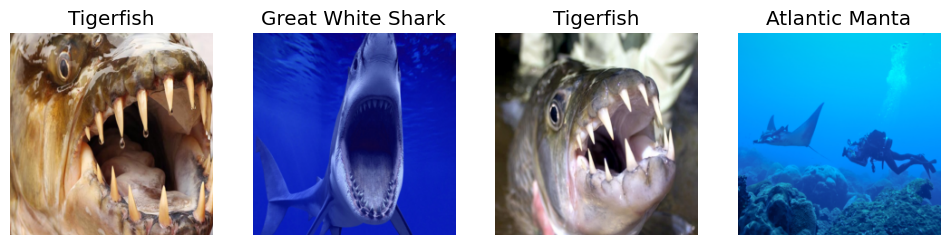

In [63]:
dls.valid.show_batch(max_n=4, nrows=1)

I trained the model a few times and found out that 10 times of finetuning is too much and overfitting, therefore, my model will stop at 7 iterations. You need to run a few time with different iteration size to train sufficiently at the same time without overfitting. 

In [67]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.973095,0.515627,0.161725,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.592603,0.356597,0.123989,01:00
1,0.455257,0.282148,0.099730,00:58
2,0.344337,0.283973,0.091644,00:59
3,0.248979,0.289170,0.072776,00:58
4,0.190581,0.270694,0.080863,00:58
5,0.152653,0.266929,0.086253,00:57
6,0.127961,0.261494,0.080863,00:58


There is still confusion between shark and meta rays in my model, there may be some resolution or similar shape between two categories, I think I will have to gather more data and retrain them in this case. But I am happy with this accuracy >90% and gonna deploy it to my prototype to demonstrate its use in an app. 

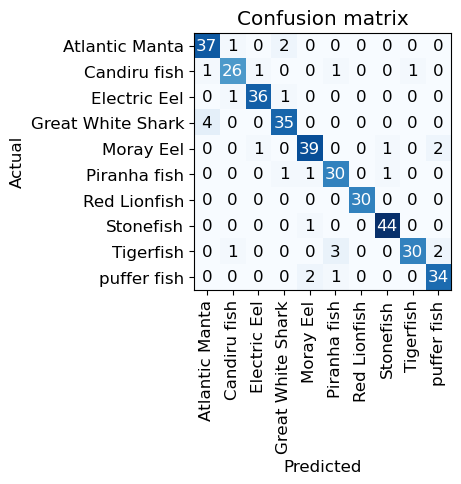

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

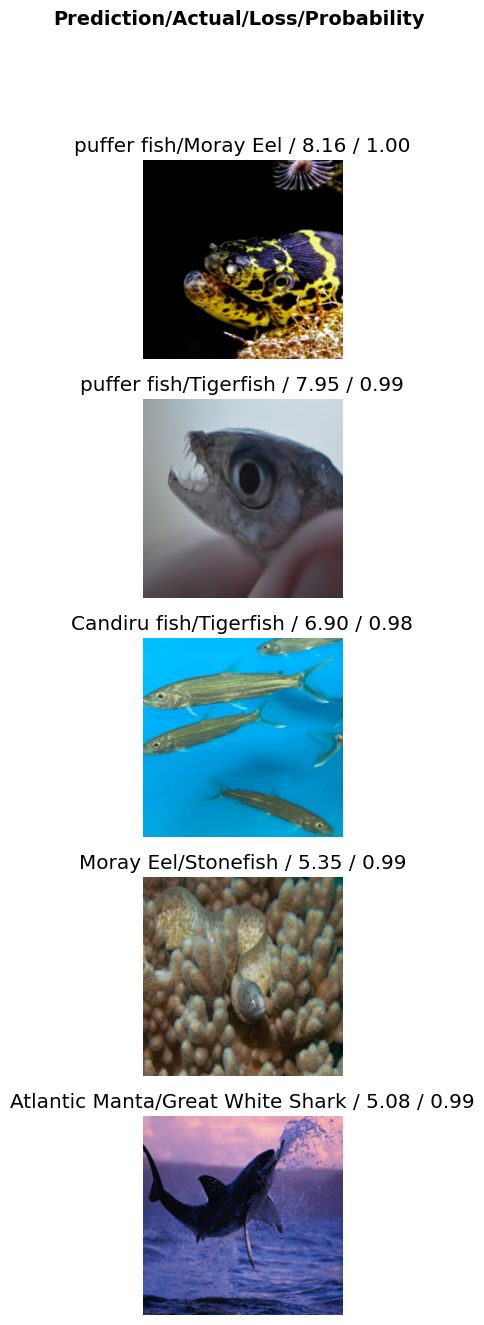

In [69]:
interp.plot_top_losses(5, nrows=5)

Exporting the model is easy and simple with learn.export(filename). Download this model and we can deploy it to hugging space to set up a web app or an API to use our model in an application. 

In [82]:
learn.export('model.pkl')